In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [48]:
# Define file paths
assessment_file = '../data/task_qla_df.csv'
activity_file = '../data/task_tia_df.feather'

assessments_df = pd.read_csv(assessment_file, index_col=0)
print(f"Assessment data loaded. Shape: {assessments_df.shape}")

activity_df = pd.read_feather(activity_file)
print(f"Activity data loaded. Shape: {activity_df.shape}")

Assessment data loaded. Shape: (5827, 10)
Activity data loaded. Shape: (459115, 14)


In [49]:
"""Initial EDA"""

print("\n--- Assessments Data: Initial EDA ---")
assessments_df.info()
print("\nMissing values (Assessments):")
print(assessments_df.isnull().sum().head()) # Show only head for brevity
print("\nSummary statistics (Assessments):")
print(assessments_df.describe(include=np.number))
if 'absent' in assessments_df.columns:
    print("\nUnique values in 'absent' column:", assessments_df['absent'].unique())

print("\n--- Activity Data: Initial EDA ---")
activity_df.info()
print("\nMissing values (Activity):")
print(activity_df.isnull().sum().head()) # Show only head for brevity
print("\nSummary statistics (Activity):")
print(activity_df.describe(include=np.number))
if 'summary' in activity_df.columns:
    print("\nData type of 'summary' column:", activity_df['summary'].dtype)

print("\nInitial EDA complete.")


--- Assessments Data: Initial EDA ---
<class 'pandas.core.frame.DataFrame'>
Index: 5827 entries, b61c4 to 75d39
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   assessment_id           5827 non-null   object 
 1   assessment_name         5827 non-null   object 
 2   n_questions_entered     5827 non-null   int64  
 3   n_questions_attempted   5827 non-null   int64  
 4   n_assessment_questions  5827 non-null   int64  
 5   absent                  5827 non-null   bool   
 6   mark                    5822 non-null   float64
 7   available_marks         5827 non-null   int64  
 8   created                 5827 non-null   object 
 9   last_updated            5827 non-null   object 
dtypes: bool(1), float64(1), int64(4), object(4)
memory usage: 460.9+ KB

Missing values (Assessments):
assessment_id             0
assessment_name           0
n_questions_entered       0
n_questions_attempted     0
n_

In [50]:
"""
Question 1: How many distinct students do we have both assessment and activity data for?
"""
if 'student_id' in assessments_df.columns:
     assessment_students = set(assessments_df['student_id'].dropna().unique())
else: # Assume it's the index
     print("Accessing student IDs from assessment data index.")
     assessment_students = set(assessments_df.index.dropna().unique())
print(f"Unique students in assessments data: {len(assessment_students)}")

activity_students = set(activity_df['student_id'].dropna().unique())
print(f"Unique students in activity data: {len(activity_students)}")

common_students = assessment_students.intersection(activity_students)
num_common_students = len(common_students)
print(f"\nNumber of distinct students with both assessment and activity data: {num_common_students}")

Accessing student IDs from assessment data index.
Unique students in assessments data: 1400
Unique students in activity data: 1394

Number of distinct students with both assessment and activity data: 1394


In [51]:

"""
Question 2: For students who completed at least two assessments,
what was the mean progress they made from one test to the next?
"""
progress_series = pd.Series([])
grouped_by_student = None

if 'student_id' not in assessments_df.columns:
    assessments_for_q2 = assessments_df.reset_index()
    if 'index' in assessments_for_q2.columns and 'student_id' not in assessments_for_q2.columns:
         assessments_for_q2 = assessments_for_q2.rename(columns={'index': 'student_id'})
else:
    assessments_for_q2 = assessments_df.copy()

if 'student_id' in assessments_for_q2.columns:
    present_assessments = assessments_for_q2[(assessments_for_q2['absent'] == False) &
                                             (assessments_for_q2['available_marks'].notna()) &
                                             (assessments_for_q2['available_marks'] > 0)].copy()

    present_assessments['pct_score'] = (present_assessments['mark'] / present_assessments['available_marks']) * 100
    present_assessments_sorted = present_assessments.sort_values(by=['student_id', 'assessment_id'])
    grouped_by_student = present_assessments_sorted.groupby('student_id')

    all_progress_values = []
    for student_id, group in grouped_by_student:
        if len(group) >= 2:
            progress = group['pct_score'].diff().dropna()
            all_progress_values.extend(progress.tolist())

    if all_progress_values:
        mean_progress = pd.Series(all_progress_values).mean()
        print(f"Mean progress between consecutive assessments (for students with >= 2): {mean_progress:.2f}%")
        progress_series = pd.Series(all_progress_values)
    else:
        print("No students found with at least two valid, consecutive assessments.")
        progress_series = pd.Series([])
else:
    print("Error: 'student_id' column not found for Q2 processing.")

Mean progress between consecutive assessments (for students with >= 2): 1.00%


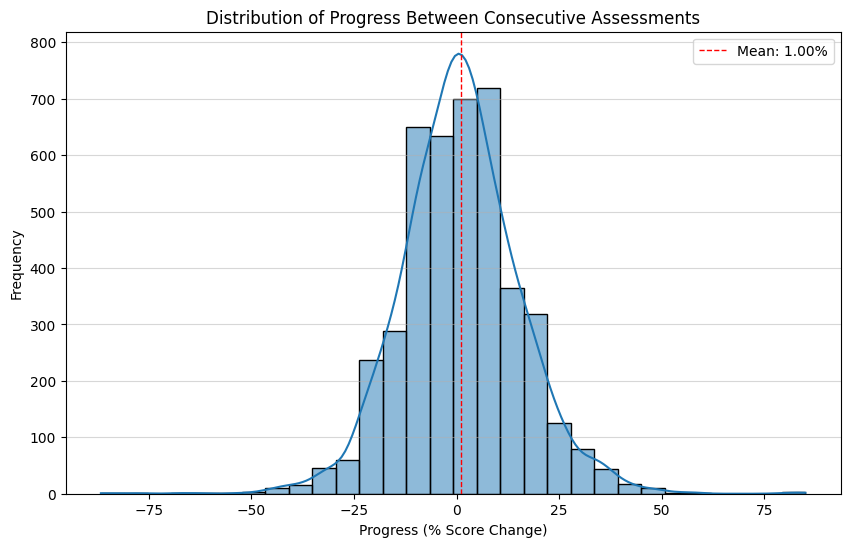

In [52]:
"""
Question 3: Plot/visualise this ‘progress’ distribution.
"""
if not progress_series.empty:
    plt.figure(figsize=(10, 6))
    sns.histplot(progress_series, kde=True, bins=30)
    plt.title('Distribution of Progress Between Consecutive Assessments')
    plt.xlabel('Progress (% Score Change)')
    plt.ylabel('Frequency')
    plt.axvline(progress_series.mean(), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {progress_series.mean():.2f}%')
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    plt.show()
else:
     print("Cannot plot for Question 3 as progress data is empty.")

In [53]:
"""
Question 4: On average, how did students perform in the second test that they sat
compared to the first? Use a statistical test.
"""
scores_df_cleaned = pd.DataFrame()

if grouped_by_student is not None:
    first_scores = []
    second_scores = []
    student_ids_q4 = []

    for student_id, group in grouped_by_student:
        if len(group) >= 2:
            student_ids_q4.append(student_id)
            first_scores.append(group['pct_score'].iloc[0])
            second_scores.append(group['pct_score'].iloc[1])

    if first_scores and second_scores:
        scores_df = pd.DataFrame({
            'student_id': student_ids_q4,
            'first_score': first_scores,
            'second_score': second_scores
        })
        scores_df_cleaned = scores_df.dropna(subset=['first_score', 'second_score'])

        if not scores_df_cleaned.empty:
            first_scores_cleaned = scores_df_cleaned['first_score']
            second_scores_cleaned = scores_df_cleaned['second_score']
            mean_diff = (second_scores_cleaned - first_scores_cleaned).mean()

            print(f"Number of students compared (after removing pairs with NaN): {len(first_scores_cleaned)}")
            print(f"Mean score on first assessment: {first_scores_cleaned.mean():.2f}%")
            print(f"Mean score on second assessment: {second_scores_cleaned.mean():.2f}%")
            print(f"Mean difference (Second - First): {mean_diff:.2f}%")

            t_stat, p_value_ttest = stats.ttest_rel(first_scores_cleaned, second_scores_cleaned)
            print(f"\nPaired t-test results:")
            print(f"  T-statistic: {t_stat:.3f}")
            print(f"  P-value: {p_value_ttest:.3g}")

            alpha = 0.05
            if p_value_ttest < alpha:
                print(f"  Conclusion: The difference is statistically significant (p < {alpha}).")
                if mean_diff > 0: print("  On average, students performed significantly better on their second assessment.")
                else: print("  On average, students performed significantly worse on their second assessment.")
            else:
                print(f"  Conclusion: The difference is not statistically significant (p >= {alpha}).")
        else:
            print("No valid pairs of scores found after removing NaNs.")
    else:
        print("No students found with at least two assessments to compare.")
else:
    print("Grouped student data not available. Cannot perform Question 4.")

Number of students compared (after removing pairs with NaN): 1388
Mean score on first assessment: 53.51%
Mean score on second assessment: 50.92%
Mean difference (Second - First): -2.59%

Paired t-test results:
  T-statistic: 6.791
  P-value: 1.64e-11
  Conclusion: The difference is statistically significant (p < 0.05).
  On average, students performed significantly worse on their second assessment.



Merged data created for exploratory analysis. Shape: (1384, 4)

--- Basic EDA on analysis_df (for Exploratory Q) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384 entries, 0 to 1383
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   student_id             1384 non-null   object 
 1   first_score            1384 non-null   float64
 2   second_score           1384 non-null   float64
 3   total_correct_answers  1384 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 43.4+ KB

Missing values:
student_id               0
first_score              0
second_score             0
total_correct_answers    0
dtype: int64

Summary statistics:
       first_score  second_score  total_correct_answers
count  1384.000000   1384.000000            1384.000000
mean     53.625963     50.981455             283.403902
std      25.809632     25.123663             143.093928
min       0.000000

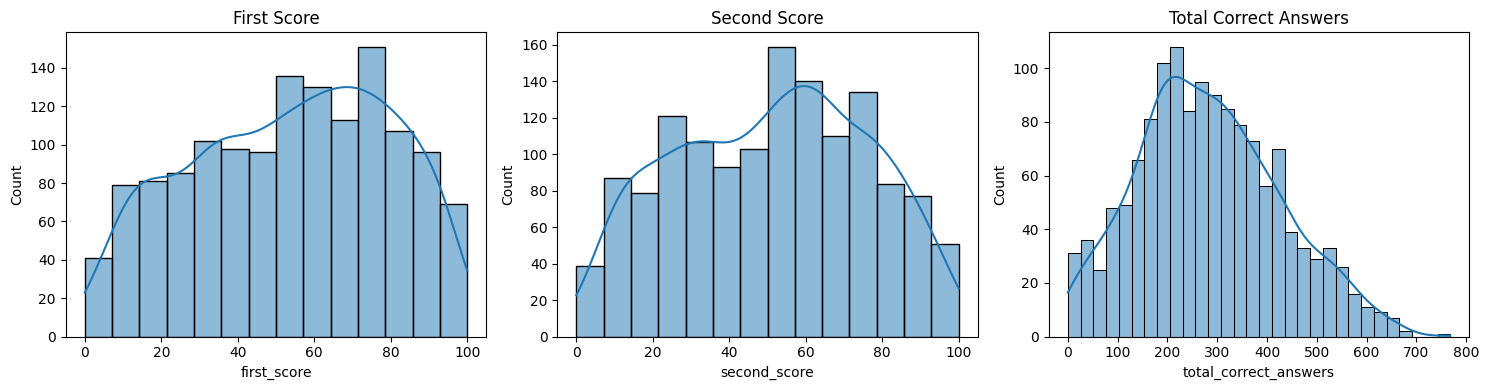

In [55]:
"""
Question 5: State one way that you might improve your confidence in your answer to question (4)
"""

# We could control for potential confounding variables like assessment difficulty or time between tests using statistical models (e.g., ANCOVA, mixed-effects models).


usage_metric = pd.DataFrame()
activity_df['is_correct'] = activity_df['summary'].astype(str).str.contains('C', na=False)
usage_metric = activity_df.groupby('student_id')['is_correct'].sum().reset_index()
usage_metric = usage_metric.rename(columns={'is_correct': 'total_correct_answers'})

analysis_df = pd.DataFrame()
if not scores_df_cleaned.empty and not usage_metric.empty:
    if 'student_id' in scores_df_cleaned.columns and 'student_id' in usage_metric.columns:
        analysis_df = pd.merge(scores_df_cleaned, usage_metric, on='student_id', how='inner')
        print(f"\nMerged data created for exploratory analysis. Shape: {analysis_df.shape}")
    else:
        print("\nError merging: 'student_id' column missing.")
else:
    print("\nCannot create merged dataframe for exploratory analysis.")

if not analysis_df.empty:
    print("\n--- Basic EDA on analysis_df (for Exploratory Q) ---")
    analysis_df.info()
    print("\nMissing values:")
    print(analysis_df.isnull().sum())
    print("\nSummary statistics:")
    print(analysis_df[['first_score', 'second_score', 'total_correct_answers']].describe())

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1); sns.histplot(analysis_df['first_score'], kde=True); plt.title('First Score')
    plt.subplot(1, 3, 2); sns.histplot(analysis_df['second_score'], kde=True); plt.title('Second Score')
    plt.subplot(1, 3, 3); sns.histplot(analysis_df['total_correct_answers'], kde=True, bins=30); plt.title('Total Correct Answers')
    plt.tight_layout(); plt.show()
else:
    print("\nSkipping EDA on analysis_df as it is empty.")